# Pianist classification using melodic and rhythmic features

## Import dependencies and set constants, etc.

In [43]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from librosa import load
from soundfile import write
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import src.visualise.visualise_utils as vutils
from src import utils
from src.detect.midi_utils import *
from src.features.melody_features import *
from src.features.rhythm_features import *

In [2]:
SEED = 42

In [3]:
smallest_n_gram = 3
largest_n_gram = 3
n_tracks_min = 10
MAX_INTERVAL = 12

## Pre-processing

In [4]:
# Get filepaths for processing
root = f'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v02/'

In [5]:
# Load in onsets and beats for each track
oms = utils.load_corpus_from_files(root)

In [6]:
# Extract melody for each track
mms = [
    MelodyMaker(
        f'{root}/{om.item["fname"]}/piano_midi.mid', 
        beats=om.ons['mix'], 
        downbeats=om.ons['downbeats_auto'], 
        tempo=om.item['tempo'], 
        time_signature=om.item['time_signature']
    ) for om in oms
]

## Create histogram of pitch classes for one random track

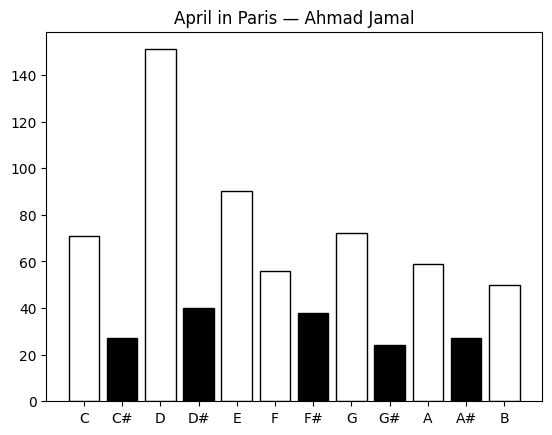

In [9]:
# Create a histogram for the pitch classes in one track
# Extract the melody for our first track
track = mms[10]
mel = list(track.extract_melody())
# Count the pitch classes
pitch_classes = Counter([m.note for m in mel])
# Sort the pitch classes in order of the piano keys
sorted_pitches = {i: pitch_classes[i] for i in utils.ALL_PITCHES}
# Create the bar chart
colors = [vutils.WHITE if '#' not in i else vutils.BLACK for i in utils.ALL_PITCHES]
plt.bar(sorted_pitches.keys(), sorted_pitches.values(), color=colors, edgecolor=vutils.BLACK)
plt.title(oms[10].item['track_name'] + ' — ' + oms[10].item['pianist'])
plt.show()

## N-gram extraction

### Extract all desired n-grams

In [10]:
res = {}
for melody, onsets in tqdm(zip(mms, oms), total=len(mms)):
    mel = list(melody.extract_melody())
    sequence = list(melody.extract_intervals(mel))
    if len(sequence) < 2:
        continue
    for start in range(len(sequence)):
        for n in range(smallest_n_gram, largest_n_gram + 1):
            n_gram = tuple([i.interval for i in sequence[start: start + n]])
            n_gram_str = str(n_gram)
            if any(abs(interval) > MAX_INTERVAL for interval in n_gram):
                continue
            if len(n_gram) == n:
                if n_gram not in res.keys():
                    res[n_gram] = {
                        'tracks': set(),
                        'pianists': set(),
                        'uses': 0,
                        'n': len(n_gram)
                    }
                res[n_gram]['tracks'].add(onsets.item['mbz_id'])
                res[n_gram]['pianists'].add(onsets.item['pianist'])
                res[n_gram]['uses'] += 1

  0%|          | 0/1294 [00:00<?, ?it/s]

### Filter to get ngrams that only appear in at least three tracks

In [11]:
valid_ngrams = set(ng for ng, vals in res.items() if len(vals['tracks']) >= n_tracks_min)

In [12]:
print('Num n-grams before filtering:', len(res.items()))
print('Num n-grams after filtering:', len(valid_ngrams))

Num n-grams before filtering: 14255
Num n-grams after filtering: 8879


### Extract only valid n-grams from entire solos (no chunks)

In [13]:
def extract_valid_ngs(track, metadata):
    valid_dict = {ng: 0 for ng in valid_ngrams}
    mel = list(track.extract_melody())
    sequence = list(track.extract_intervals(mel))
    track_res = {
        'pianist': metadata.item['pianist'], 
        'track_name': metadata.item['track_name'], 
        'mbz_id': metadata.item['mbz_id'], 
        **valid_dict
    }
    for start in range(len(sequence)):
        for n in range(smallest_n_gram, largest_n_gram + 1):
            n_gram = tuple([i.interval for i in sequence[start: start + n]])
            if len(n_gram) == n:
                if n_gram not in valid_ngrams:
                    continue
                track_res[n_gram] += 1
    return track_res

In [14]:
with Parallel(n_jobs=-1, verbose=5) as par:
    all_ngs = par(delayed(extract_valid_ngs)(t, m) for t, m in zip(mms, oms))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 1294 out of 1294 | elapsed:   17.8s finished


To ensure repeatable outputs, we need to ensure that our samples and features always follow the same order

In [15]:
df = (
    pd.DataFrame(all_ngs)
    .set_index(['pianist', 'track_name', 'mbz_id'])
    .sort_index()
)

In [16]:
print(df.shape)

(1294, 8879)


## Plot descriptive statistics for all n-grams 

### Plot ten most common n-grams in terms of overall uses and number of pianists

In [17]:
big10 = (
    df.sum()
    .sort_values(ascending=False)
    .head(15)
    .reset_index(drop=False)
    .rename(columns={'index': 'ngram', 0: 'count'})
)
big10['ngram'] = big10['ngram'].astype(str)

In [18]:
big10vals = big10['ngram'].values

In [19]:
npianists = (
    df.groupby(level=0)
    [df.columns]
    .sum()
    .astype(bool)
    .astype(int)
    .sum()
    .reset_index(drop=False)
    .rename(columns={'index': 'ngram', 0: 'pianists'})
)
npianists['ngram'] = npianists['ngram'].astype(str)
npianists['pianists'] = ((npianists['pianists'] / df.index.get_level_values(0).nunique()) * 100).astype(int)

In [20]:
mostplayed = npianists[npianists['ngram'].isin(big10vals)]['pianists'].values

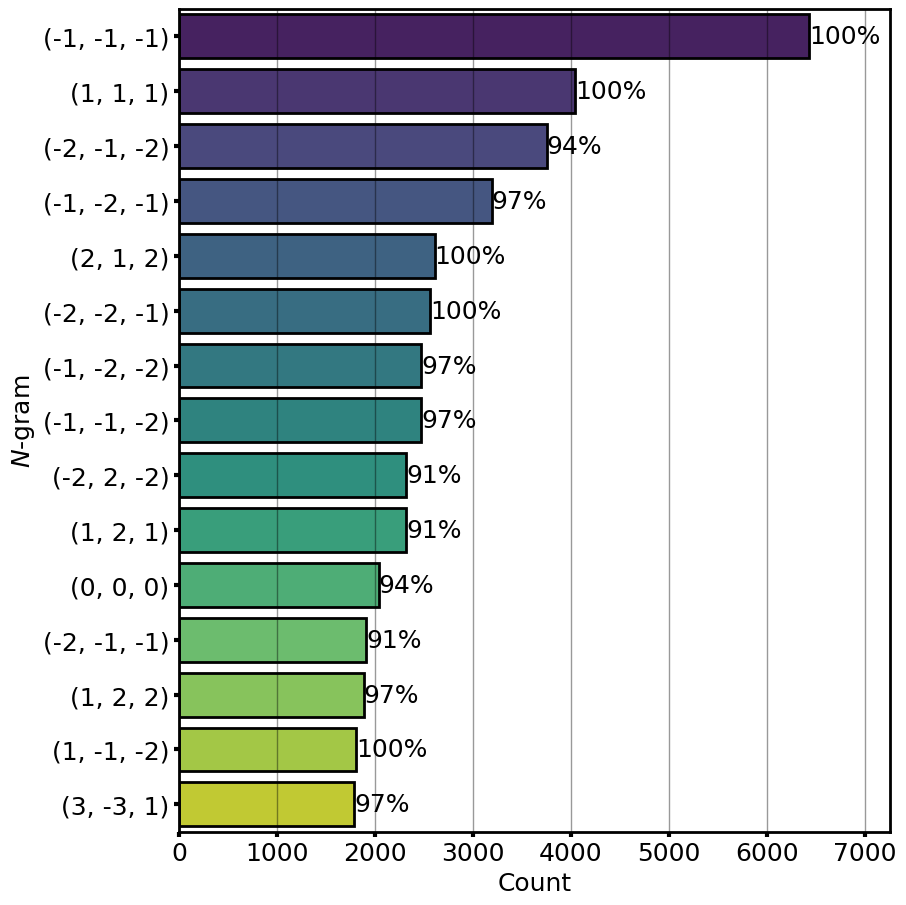

In [73]:
plt.rcParams.update({'font.size': vutils.FONTSIZE})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2), sharey=True)
g = sns.barplot(
    data=big10, x='count', y='ngram', orient='h', hue='ngram', legend=False, palette='viridis', ax=ax,
    linewidth=vutils.LINEWIDTH, edgecolor=vutils.BLACK
)
for cont, lab in zip(g.containers, mostplayed):
    ax.bar_label(container=cont, labels=[f'{lab}%'])
ax.set(ylabel='$N$-gram', xlabel='Count', xlim=(0, ax.get_xlim()[1] + 500))
ax.grid(axis='x', zorder=0, **vutils.GRID_KWS)
plt.setp(ax.spines.values(), linewidth=vutils.LINEWIDTH)
ax.tick_params(axis='both', width=vutils.TICKWIDTH)
fig.tight_layout()
fig.savefig(f'{utils.get_project_root()}/reports/figures/ngram_plots/barplot_most_used_3grams.png')
plt.show()

## Which n-grams are most representative of Bill Evans?
- For all tracks, we assign a value of 1 = Evans, 0 = not Evans, which we'll try and predict
- We then split the dataset into 5 folds, with 4:1 test-train split (with folds stratified such that the number of BE/non-BE tracks are equal)
- We fit a logistic regression to each fold, and extract the coefficients from this
- We average the coefficients across all folds, and extract odds ratios
- This gives us the direction of each n-gram: if positive, it is more likely to be predictive of Bill Evans

In [22]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [23]:
X = df.values
y = np.array([0 if i != 'Bill Evans' else 1 for i in df.index.get_level_values(0)])

In [24]:
# Need to scale the data for svms (i.e. Z-score)?
X_scale = StandardScaler().fit_transform(X)
X_scale.shape

(1294, 8879)

In [25]:
def fit(permutation):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=permutation)
    estimator = LogisticRegression(random_state=SEED, penalty='l2', solver='lbfgs')
    estimator.fit(X_train, y_train)
    y_predict = estimator.predict(X_test)
    return accuracy_score(y_test, y_predict), roc_auc_score(y_test, y_predict), estimator.coef_

In [26]:
with Parallel(n_jobs=-1, verbose=5) as par:
    accs, rocs, coefs = zip(*par(delayed(fit)(i) for i in range(1000)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.7min finished


In [27]:
cdf = pd.DataFrame(np.exp(np.vstack(coefs)))
cdf.columns = df.columns
# Stupid pandas.agg not working correctly when you have arguments: https://stackoverflow.com/questions/68091853/
res = (
    pd.DataFrame([dict(ng=col, mean=cdf[col].mean(), low=np.quantile(cdf[col], 0.025), high=np.quantile(cdf[col], 0.975)) for col in cdf.columns])
    .sort_values(by='mean')
    .reset_index(drop=True)
)

### Visualise the ten most and least "Bill Evans"-y n-grams

In [53]:
most_be = pd.concat([res.head(10), pd.DataFrame([dict(ng='', mean=np.nan, low=np.nan, high=np.nan)]), res.tail(10)]).reset_index(drop=True)
# most_be['ng'] = most_be['ng'].astype(str)
most_be['low'] = most_be['mean'] - most_be['low']
most_be['high'] = most_be['high'] - most_be['mean']
most_be['hue'] = most_be['mean'] < 1

In [62]:
most_be['proportion'] = np.nan
for i, row in most_be.iterrows():
    if row['ng'] == '':
        continue
    grp = df.groupby(level=0)[[row['ng']]]
    sums = df.groupby(level=0).sum().sum(axis=1)
    prop = (grp.sum().squeeze() / sums) * 100
    nonbe = prop[prop.index != 'Bill Evans'].mean()
    be = prop[prop.index == 'Bill Evans'].iloc[0]
    most_be.loc[i, 'proportion'] = f'{round(be / nonbe, 1)}x'

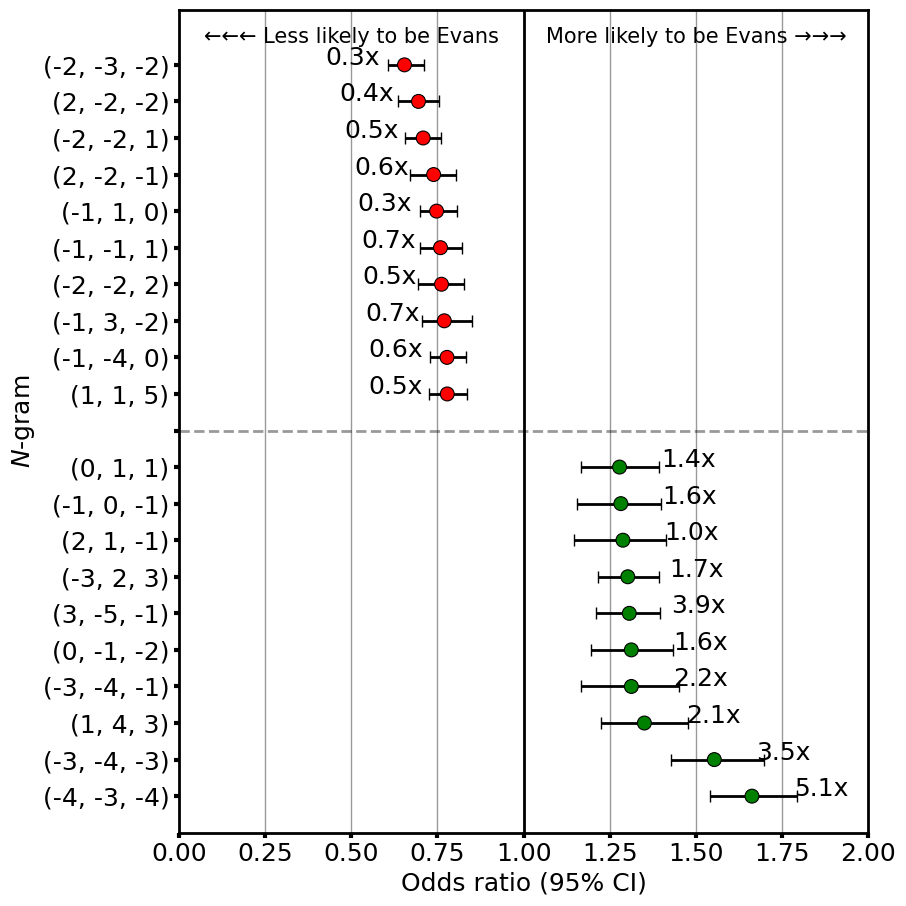

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))
most_be['ng_s'] = most_be['ng'].astype(str)
ax.errorbar(
    x=most_be['mean'], y=most_be['ng_s'], xerr=[most_be['low'], most_be['high']], lw=vutils.LINEWIDTH, 
    color=vutils.BLACK, capsize=4, zorder=0, elinewidth=vutils.LINEWIDTH, ls='none'
)
sns.scatterplot(
    data=most_be, x='mean', y='ng_s', ax=ax, hue='hue', palette=[vutils.GREEN, vutils.RED], 
    legend=False, s=100, edgecolor=vutils.BLACK, zorder=10
)
ax.set(xlabel='Odds ratio (95% CI)', ylabel='$N$-gram', xlim=(0, 2), ylim=(21, -1.5))
ax.grid(axis='x', zorder=0, **vutils.GRID_KWS)
ax.axhline(10, 0, 1, linewidth=vutils.LINEWIDTH, color=vutils.BLACK, alpha=vutils.ALPHA, ls='dashed')
ax.axvline(1, 0, 1, linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
ax.text(1.5, -0.5, 'More likely to be Evans →→→', fontsize=15, ha='center', va='bottom')
ax.text(0.5, -0.5, '←←← Less likely to be Evans', fontsize=15, ha='center', va='bottom')

for idx, row in most_be.iterrows():
    ax.text(row['mean'] + 0.2 if row['mean'] > 1 else row['mean'] - 0.15, idx, row['proportion'], ha='center')

plt.setp(ax.spines.values(), linewidth=vutils.LINEWIDTH)
ax.tick_params(axis='both', width=vutils.TICKWIDTH)
fig.tight_layout()
fig.savefig(f'{utils.get_project_root()}/reports/figures/ngram_plots/stripplot_evans_3gram_oddsratios.png')
plt.show()

5.091919602359708


### Audiate examples

In [46]:
def get_audio(audio_fname, sta, sto, pad_secs: int = 1, overlap_secs: float = 0.1):
    sta *= utils.SAMPLE_RATE
    sto *= utils.SAMPLE_RATE
    sta -= (overlap_secs * utils.SAMPLE_RATE)
    sto += (overlap_secs * utils.SAMPLE_RATE)
    audio, _ = load(audio_fname, sr=utils.SAMPLE_RATE)
    trunc = audio[int(sta): int(sto)]
    return np.hstack((trunc, np.zeros(utils.SAMPLE_RATE * pad_secs)))

def extract_audio_from_ngram(mmake, audio_fname, desired_ng: tuple):
    mel = list(mmake.extract_melody())
    sequence = list(mmake.extract_intervals(mel))
    track_audio = []
    for start in range(len(sequence)):
        for n in range(smallest_n_gram, largest_n_gram + 1):
            trunc = sequence[start: start + n]
            n_gram = tuple([i.interval for i in trunc])
            if n_gram == desired_ng:
                start = trunc[0].start
                end = trunc[-1].start + trunc[-1].ioi
                extracted = get_audio(audio_fname, start, end)
                track_audio.extend(extracted.tolist())
    return track_audio

def write_audio(out_fname, audio_list):
    with open(out_fname, 'wb') as f:
        write(f, np.hstack(audio_list), utils.SAMPLE_RATE)

In [47]:
with Parallel(n_jobs=-1, verbose=5) as par:
    all_audio_maj7 = par(delayed(extract_audio_from_ngram)(
        mm, f'{utils.get_project_root()}/data/raw/audio/{meta.item["fname"]}.wav', (-4, -3, -4)
    ) for mm, meta in zip(mms, oms) if meta.item['bandleader'] == 'Bill Evans')
write_audio(f'{utils.get_project_root()}/evans_maj7.wav', all_audio_maj7)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    3.2s finished


In [49]:
with Parallel(n_jobs=-1, verbose=5) as par:
    all_audio_min7 = par(delayed(extract_audio_from_ngram)(
        mm, f'{utils.get_project_root()}/data/raw/audio/{meta.item["fname"]}.wav', (-3, -4, -3)
    ) for mm, meta in zip(mms, oms) if meta.item['bandleader'] == 'Bill Evans')
write_audio(f'{utils.get_project_root()}/evans_min7.wav', all_audio_min7)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:   16.1s finished


### Model fitting

Tree-based methods
- Random Forest ✅
- Gradient-Boosted Trees ✅

Non-Tree based ML:
- SVM ✅
- Naive Bayes
- Multiclass logistic regression

DL
- Perceptron (ANN)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Split the data into predictors and response
X = tracks.iloc[:, 3:].to_numpy()
y = tracks.iloc[:, 0].to_numpy()
# Express n-gram numbers as percentage of total track
X = np.true_divide(X, X.sum(axis=1, keepdims=True))

In [ ]:
def initial_fit(estimator):
    accs = []
    for train_idx, test_idx in tqdm(cv.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        estimator.fit(X_train, y_train)
        y_predict = estimator.predict(X_test)
        acc = accuracy_score(y_test, y_predict)
        accs.append(acc)
    return np.mean(accs)

In [ ]:
cv = StratifiedKFold(random_state=42, n_splits=5, shuffle=True)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False)

In [ ]:
# Testing using default parameters
rf_acc = initial_fit(rf)
print(rf_acc)

- 58% using only n-grams contained in at least 3 solos
- 50% using all n-grams!

### Gradient boosted trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(random_state=42, verbose=0, max_features='sqrt')

In [ ]:
# Testing using default parameters
gbc_acc = initial_fit(gbc)
print(gbc_acc)

### Support Vector Machines

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(random_state=42, decision_function_shape='ovo', verbose=0)

In [ ]:
# Need to scale the data for svms (i.e. Z-score)
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler().fit_transform(X, y)

In [ ]:
# Testing using default parameters
svc_acc = initial_fit(svc)
print(svc_acc)

Without tuning, RF outperforms gradient boosted trees and SVC

## Initial hyperparameter optimisation
Find some sensible values to use prior to RF feature selection

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# These are the parameters we'll sample from when optimizing
test_params = dict(
    # the loss function to use when splitting a node
    criterion=['gini', 'entropy', 'log_loss'],
    # The number of trees to grow in the forest
    n_estimators=[i for i in range(10, 200, 10)],
    # Max number of features considered for splitting a node
    max_features=[None, 'sqrt', 'log2'],
    # Max number of levels in each tree
    max_depth=[None, *[i for i in range(1, 51, 10)]],
    # Minimum number of samples required to split a node
    min_samples_split=[i for i in range(2, 11)],
    # Minimum number of samples required at each leaf node
    min_samples_leaf=[i for i in range(1, 11)],
    # Whether to sample data points with our without replacement
    bootstrap=[True, False],
)

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False)
rs = RandomizedSearchCV(rf, param_distributions=test_params, cv=cv, random_state=42, n_iter=1000, verbose=5)

In [ ]:
rs.fit(X, y)

In [ ]:
rs.best_params_

In [ ]:
# {'n_estimators': 170,
 # 'min_samples_split': 10,
 # 'min_samples_leaf': 2,
 # 'max_features': 'sqrt',
 # 'max_depth': 21,
 # 'criterion': 'gini',
 # 'bootstrap': False}

In [ ]:
# Hard-coded results from running the above
initial_params = {'n_estimators': 190,
                  'min_samples_split': 8,
                  'min_samples_leaf': 3,
                  'max_features': 'sqrt',
                  'max_depth': 41,
                  'criterion': 'gini',
                  'bootstrap': False}

## Feature selection from random forest
Considering only the *n*th percentile of most important features 

In [ ]:
rf_initial = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False, **initial_params)

In [ ]:
def get_importances(X_, y_, est = None) -> float:
    if est is None:
        est = rf_initial
    imports = []
    for train_idx, test_idx in cv.split(X_, y_):
        X_train, y_train = X_[train_idx], y_[train_idx]
        X_test, y_test = X_[test_idx], y_[test_idx]
        rf_initial.fit(X_train, y_train)
        imports.append(rf_initial.feature_importances_)
    return imports

def get_most_important_feature_idxs(imports, n: int = 95):
    means = np.mean(np.vstack(imports), axis=0)
    order = means.argsort()
    ranks = order.argsort()
    perc = (len(ranks) / 100) * n
    to_keep = np.argwhere(ranks > perc)[:, 0]
    return to_keep

def get_accuracy(X_d, y_):
    accs = []
    for train_idx, test_idx in cv.split(X_d, y_):
        X_train, y_train = X_d[train_idx], y_[train_idx]
        X_test, y_test = X_d[test_idx], y_[test_idx]
        rf_initial.fit(X_train, y_train)
        y_predict = rf_initial.predict(X_test)
        acc = accuracy_score(y_test, y_predict)
        accs.append(acc)
    return np.mean(accs)


measures = []
imports = get_importances(X, y)
for n in tqdm(range(0, 95, 1)):
    n_imports = get_most_important_feature_idxs(imports, n)
    measures.append((100 - n, get_accuracy(X[:, n_imports], y)))

In [ ]:
measures_df = pd.DataFrame(measures)
plt.plot(measures_df[0], measures_df[1])
plt.ylabel('Mean accuracy across all folds ($k$=5)')
plt.xlabel('% of all features considered')
plt.title('Values show smoothed averages (window=10%)')

In [ ]:
perc_features_to_keep = measures_df.iloc[measures_df[1].sort_values(ascending=False).index[1], 0]
# perc_features_to_keep = 34
n_imports = get_most_important_feature_idxs(imports, 100 - perc_features_to_keep)

In [ ]:
X_min_features = X[:, n_imports]
print(get_accuracy(X_min_features, y), perc_features_to_keep)

We only need to include the ~33% most important features to obtain similar accuracy when compared to including all predictors

## Final hyperparameter optimisation

**TODO**

## Plot confusion matrix

In [ ]:
preds = []
acts = []
ids = []
for train_idx, test_idx in tqdm(cv.split(X_min_features, y)):
    X_train, y_train = X_min_features[train_idx], y[train_idx]
    X_test, y_test = X_min_features[test_idx], y[test_idx]
    rf_initial.fit(X_train, y_train)
    y_predict = rf_initial.predict(X_test)
    preds.extend(y_predict)
    acts.extend(y_test)
    ids.extend(tracks.iloc[test_idx, 2].values)

In [ ]:
pred_df = (
    pd.concat([pd.Series(ids), pd.Series(acts), pd.Series(preds)], axis=1)
    .rename(columns={0: 'mbz_id', 1: 'actual', 2: 'predicted'})
    .apply(lambda x: [i.split(' ')[-1] for i in x])
    .sort_values(by='actual')
    .reset_index(drop=True)
)

In [ ]:
import seaborn as sns
labs = pred_df['actual'].unique()
cm = confusion_matrix(pred_df['actual'], pred_df['predicted'], normalize='true')
g = sns.heatmap(cm, cmap='Reds', annot=True, fmt='.2f')
g.set_xticks(g.get_xticks(), labels=labs, rotation=90)
g.set_yticks(g.get_yticks(), labels=labs, rotation=00)
g.set(xlabel='Predicted', ylabel='Actual')

## Most indicative n-gram for each particular pianist
- Fit binary classifier - i.e. is it John Hicks vs someone else? - and extract feature importances
    - How to get direction (i.e. this n-gram definitely makes it Hicks, or means its definitely not Hicks?)
    - Possibly -- extract *n* most important n-grams from binary random forest, fit logistic regression using these, check log odds?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
pianist_labels, y_int = np.unique(y, return_inverse=True)

In [ ]:
from joblib import Parallel, delayed
from sklearn.exceptions import ConvergenceWarning
import warnings

# We don't care that the model won't converge now and will bruteforce this later by increasing max_iter
warnings.simplefilter('ignore', ConvergenceWarning, )

fs = []
accs = []
c_range = range(10, 100)


def predict(c_):
    lr = LogisticRegression(C=c_, penalty='l2', random_state=42, solver='lbfgs', multi_class='ovr', n_jobs=1, max_iter=100)
    accs = []
    fs = []
    for train_idx, test_idx in cv.split(X_min_features, y_int):
        X_train, y_train = X_min_features[train_idx], y_int[train_idx]
        X_test, y_test = X_min_features[test_idx], y_int[test_idx]
        lr.fit(X_train, y_train)
        yhat = lr.predict(X_test)
        f = f1_score(y_test, yhat, average='macro')
        acc = accuracy_score(y_test, yhat)
        fs.append(f)
        accs.append(acc)
    return c_, np.mean(f), np.mean(acc)

with Parallel(n_jobs=-1, verbose=5) as par:
    cv_res = par(delayed(predict)(c) for c in range(5, 100))

In [ ]:
best_c = 58
print(predict(c_=best_c))

In [ ]:
cols = tracks.columns[3:]
for p in range(10):
    pianist = pianist_labels[p]
    best = cols[n_imports[np.argmax(np.square(lr.coef_[p, :]))]]
    worst = cols[n_imports[np.argmin(np.square(lr.coef_[p, :]))]]
    print(pianist, best, worst)
    print(tracks[tracks['pianist'] == pianist][best].sum())
    print(tracks[best].sum())
    print(tracks[tracks['pianist'] == pianist][worst].sum())
    print(tracks[worst].sum())
    # print(X_min_features[np.argmin(np.square(lr.coef_[p, :]))])

In [ ]:
lr = LogisticRegression(C=best_c, penalty='l2', random_state=42, solver='lbfgs', multi_class='multinomial', n_jobs=1, max_iter=100)
lr.fit(X_min_features, y_int)

## Integrating rhythmic features


In [ ]:
rhythm = pd.read_csv(f'{utils.get_project_root()}/notebooks/prediction/rhythm_features.csv', index_col=0).reset_index(drop=True)
rhythm['mbz_id'].dtype

In [ ]:
X_sort = np.hstack((
    tracks.sort_values('mbz_id').reset_index(drop=True).iloc[:, 3:].to_numpy()[:, n_imports],
    rhythm.iloc[:, 3:].to_numpy()
))
y_sort = tracks.sort_values('mbz_id').reset_index(drop=True).iloc[:, 0].to_numpy()

In [ ]:
imports = get_importances(X_sort, y_sort)
measures = []
for n in tqdm(range(0, 95, 1)):
    n_imports = get_most_important_feature_idxs(imports, n)
    ac = get_accuracy(X_sort[:, n_imports], y_sort)
    print(n, ac)
    measures.append((100 - n, ac))

In [ ]:
from joblib import Parallel, delayed
from sklearn.exceptions import ConvergenceWarning
import warnings

# We don't care that the model won't converge now and will bruteforce this later by increasing max_iter
warnings.simplefilter('ignore', ConvergenceWarning, )

fs = []
accs = []
c_range = range(10, 100)


def predict(c_):
    lr = LogisticRegression(C=c_, penalty='l2', random_state=42, solver='lbfgs', multi_class='ovr', n_jobs=1, max_iter=100)
    accs = []
    fs = []
    for train_idx, test_idx in cv.split(X_min_features, y_int):
        X_train, y_train = X_min_features[train_idx], y_int[train_idx]
        X_test, y_test = X_min_features[test_idx], y_int[test_idx]
        lr.fit(X_train, y_train)
        yhat = lr.predict(X_test)
        f = f1_score(y_test, yhat, average='macro')
        acc = accuracy_score(y_test, yhat)
        fs.append(f)
        accs.append(acc)
    return c_, np.mean(f), np.mean(acc)

with Parallel(n_jobs=-1, verbose=5) as par:
    cv_res = par(delayed(predict)(c) for c in range(5, 100))

In [ ]:
best_c = 58
print(predict(c_=best_c))

In [ ]:
cols = tracks.columns[3:]
for p in range(10):
    pianist = pianist_labels[p]
    best = cols[n_imports[np.argmax(np.square(lr.coef_[p, :]))]]
    worst = cols[n_imports[np.argmin(np.square(lr.coef_[p, :]))]]
    print(pianist, best, worst)
    print(tracks[tracks['pianist'] == pianist][best].sum())
    print(tracks[best].sum())
    print(tracks[tracks['pianist'] == pianist][worst].sum())
    print(tracks[worst].sum())
    # print(X_min_features[np.argmin(np.square(lr.coef_[p, :]))])

In [ ]:
lr = LogisticRegression(C=best_c, penalty='l2', random_state=42, solver='lbfgs', multi_class='multinomial', n_jobs=1, max_iter=100)
lr.fit(X_min_features, y_int)

## Integrating rhythmic features


In [ ]:
rhythm = pd.read_csv(f'{utils.get_project_root()}/notebooks/prediction/rhythm_features.csv', index_col=0).reset_index(drop=True)
rhythm['mbz_id'].dtype

In [ ]:
X_sort = np.hstack((
    tracks.sort_values('mbz_id').reset_index(drop=True).iloc[:, 3:].to_numpy()[:, n_imports],
    rhythm.iloc[:, 3:].to_numpy()
))
y_sort = tracks.sort_values('mbz_id').reset_index(drop=True).iloc[:, 0].to_numpy()

In [ ]:
imports = get_importances(X_sort, y_sort)
measures = []
for n in tqdm(range(0, 95, 1)):
    n_imports = get_most_important_feature_idxs(imports, n)
    ac = get_accuracy(X_sort[:, n_imports], y_sort)
    print(n, ac)
    measures.append((100 - n, ac))